<a href="https://colab.research.google.com/github/rishicarter/Tensorflow_fundamentals/blob/main/06_TransferLearning_Scalingup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Jul 24 21:46:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-24 22:56:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-24 22:56:36 (83.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# imports
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

from sklearn.metrics import accuracy_score, classification_report

# 10% data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-07-24 22:58:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  89.8MB/s    in 18s     

2022-07-24 22:59:11 (85.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data('101_food_classes_10_percent.zip')
walk_through_dir('101_food_classes_10_percent')

train_dir='101_food_classes_10_percent/train'
test_dir='101_food_classes_10_percent/test'

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/panna_cotta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/paella'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images

In [ ]:
IMG_SIZE=(224,224)
train_data_10p = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     label_mode='categorical',
                                                                     image_size=IMG_SIZE)
test_data_10p= tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                   label_mode='categorical',
                                                                   image_size=IMG_SIZE,
                                                                   shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## MODEL_1

In [ ]:
#create modelcheckpoint callback
checkpoint_path = 'modelcheckpoint'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weights_only=True,
                                                       save_best_only=True,
                                                       monitor='val_accuracy')

In [ ]:
#Create data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [ ]:
#create a transfer learning feature extraction model

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=(224,224,3), name='input_layer')
x=data_augmentation(inputs)

x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name='pooling_layer')(x)

outputs = layers.Dense(len(train_data_10p.class_names), activation='softmax',
                       name='output_layer')(x)
model_1=tf.keras.Model(inputs,outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                              

In [ ]:
hist_1 = model_1.fit(train_data_10p,
                     epochs=5,
                     validation_data=test_data_10p,
                     validation_steps=int(0.15*len(test_data_10p)),
                     callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 95s 328ms/step - loss: 3.4537 - accuracy: 0.2462 - val_loss: 2.6357 - val_accuracy: 0.4277
Epoch 2/5
237/237 [==============================] - 62s 259ms/step - loss: 2.3618 - accuracy: 0.4585 - val_loss: 2.2141 - val_accuracy: 0.4735
Epoch 3/5
237/237 [==============================] - 54s 227ms/step - loss: 1.9847 - accuracy: 0.5299 - val_loss: 2.0739 - val_accuracy: 0.4846
Epoch 4/5
237/237 [==============================] - 50s 208ms/step - loss: 1.7770 - accuracy: 0.5710 - val_loss: 1.9660 - val_accuracy: 0.5029
Epoch 5/5
237/237 [==============================] - 48s 200ms/step - loss: 1.6327 - accuracy: 0.5991 - val_loss: 1.9478 - val_accuracy: 0.5008


In [ ]:
fine_tuning_results_1=model_1.evaluate(test_data_10p)
fine_tuning_results_1

790/790 [==============================] - 64s 80ms/step - loss: 1.7258 - accuracy: 0.5489


[1.725796103477478, 0.548910915851593]

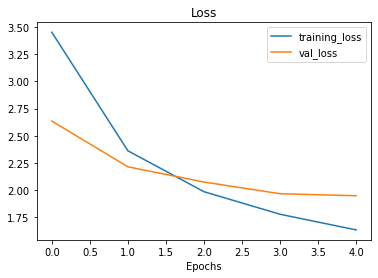

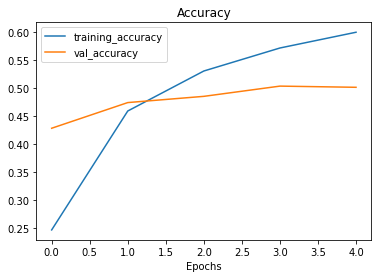

In [ ]:
plot_loss_curves(hist_1)

## MODEL_2

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-5]:
  base_model.trainable=False

In [ ]:
# Recompile
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [ ]:
for layer in model_1.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
pooling_layer True
output_layer True


In [ ]:
total_epochs = 10
# weights=checkpoint_callback.

In [ ]:
hist_1_2 = model_1.fit(train_data_10p,
                       epochs=total_epochs,
                       validation_data=test_data_10p,
                       validation_steps=int(0.15*len(test_data_10p)),
                       initial_epoch=hist_1.epoch[-1])

237/237 [==============================] - 42s 173ms/step - loss: 1.4340 - accuracy: 0.6587 - val_loss: 1.9155 - val_accuracy: 0.5042
Epoch 7/10
237/237 [==============================] - 43s 180ms/step - loss: 1.4217 - accuracy: 0.6618 - val_loss: 1.9061 - val_accuracy: 0.5045
Epoch 8/10
237/237 [==============================] - 41s 170ms/step - loss: 1.4126 - accuracy: 0.6653 - val_loss: 1.8955 - val_accuracy: 0.5069
Epoch 9/10
237/237 [==============================] - 40s 168ms/step - loss: 1.3918 - accuracy: 0.6698 - val_loss: 1.8937 - val_accuracy: 0.5087
Epoch 10/10
237/237 [==============================] - 38s 161ms/step - loss: 1.3772 - accuracy: 0.6741 - val_loss: 1.8945 - val_accuracy: 0.5082


In [ ]:
fine_tuning_results_1_2=model_1.evaluate(test_data_10p)
fine_tuning_results_1_2

790/790 [==============================] - 57s 72ms/step - loss: 1.6719 - accuracy: 0.5617


[1.671866536140442, 0.5616633892059326]

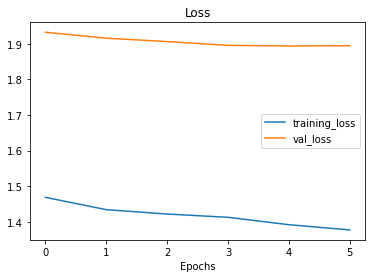

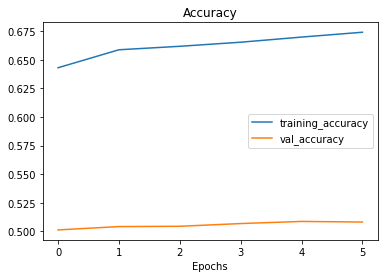

In [ ]:
plot_loss_curves(hist_1_2)

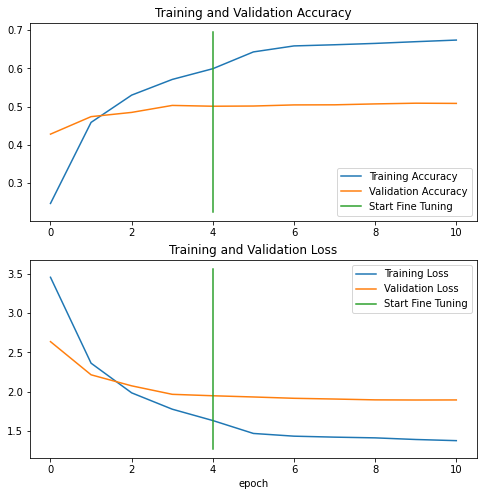

In [ ]:
compare_historys(hist_1, hist_1_2)

## saving and loading model



In [ ]:
model_1.save('drive/MyDrive/TFmodels/model_1_10per_model')

INFO:tensorflow:Assets written to: drive/MyDrive/TFmodels/model_1_10per_model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/TFmodels/model_1_10per_model/assets


In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/TFmodels/model_1_10per_model')

In [ ]:
loaded_model.evaluate(test_data_10p)

790/790 [==============================] - 59s 73ms/step - loss: 1.6719 - accuracy: 0.5617


[1.671866536140442, 0.5616633892059326]

# Evaluate across all images

In [ ]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-07-24 22:56:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  22.6MB/s    in 2.0s    

2022-07-24 22:56:42 (22.6 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
model.evaluate(test_data_10p)

790/790 [==============================] - 60s 74ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [ ]:
model.summary()

Model: "functional_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
______________________________________

## Making preds on trained model

In [ ]:
pred_probs = model.predict(test_data_10p, verbose=1)

378/790 [=============>................] - ETA: 10:32

In [ ]:
pred_probs.shape

In [ ]:
pred_probs[0][np.argmax(pred_probs[0])]

In [ ]:
pred_classes = pred_probs.argmax(axis=1)

In [ ]:
# Unravel test data

y_labels = []
for images, labels in test_data_10p.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

In [ ]:
## evaluating model predictions

accuracy_score(y_labels, pred_classes)

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
## confusion matrix
class_names = test_data_10p.class_names

make_confusion_matrix(y_true=y_labels,y_pred=pred_classes,
                      classes=class_names, figsize=(100,100),
                      text_size=20, savefig=True)

In [ ]:
# Classification report
print(classification_report(y_labels, pred_classes))

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [ ]:
class_f1_scores = {}
for k,v in classification_report_dict.items():
  if k=='accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]]=v['f1-score']
class_f1_scores

In [ ]:
f1_scores = pd.DataFrame({'class_names':list(class_f1_scores.keys()),
                          'f1-score':list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

In [ ]:
f1_scores.head()

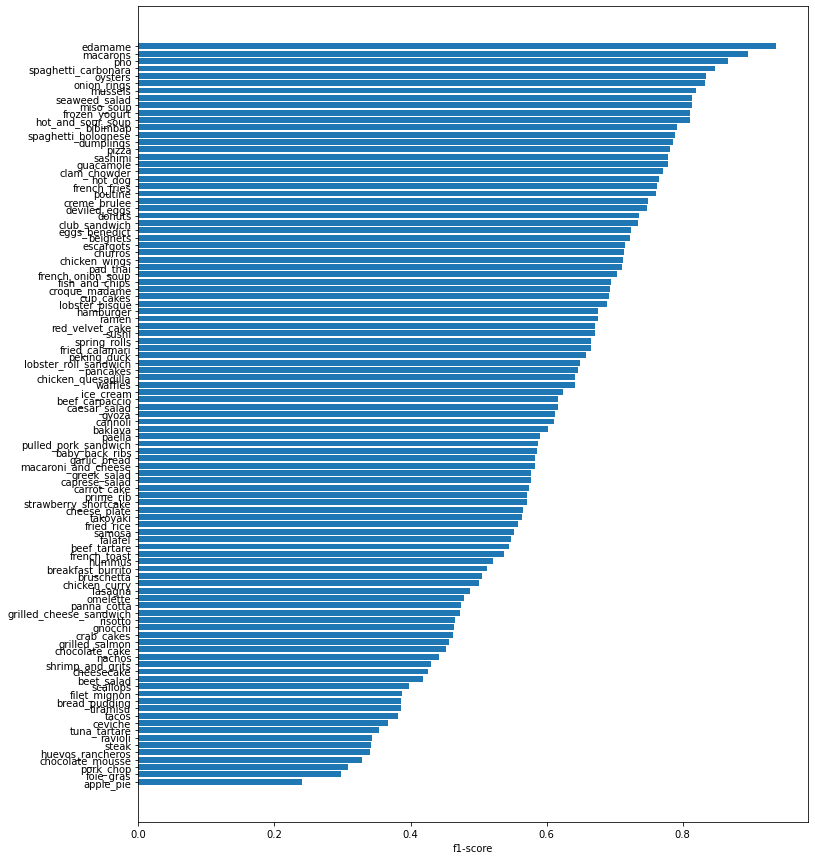

In [ ]:
fig, ax = plt.subplots(figsize=(12,15))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('f1-score')
ax.invert_yaxis();

In [ ]:
def load_prep_images(filename, img_shape=224, scale=True):
  
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

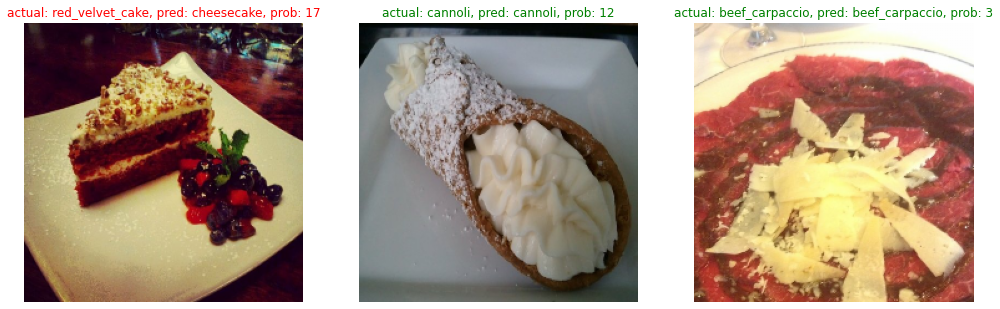

In [ ]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  file_name = random.choice(os.listdir(test_dir+'/'+class_name))
  filepath = test_dir+'/'+class_name+'/'+file_name
  img = load_prep_images(filepath, scale=False)
  img_e=tf.expand_dims(img,axis=0)
  pred_prob=model.predict(img_e)
  pred_max=pred_prob.argmax()
  pred_class = class_names[pred_max]

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color='g'
  else:
    title_color='r'
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_max}",c=title_color)
  plt.axis(False);


In [ ]:
filepaths = []
for filepath in test_data_10p.list_files('/content/101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
pred_df = pd.DataFrame({'img_path':filepaths,
                        'y_true':y_labels,
                        'y_pred':pred_classes,
                        'pred_conf': pred_probs.max(axis=1),
                        'y_true_class': [class_names[i] for i in y_labels],
                        'y_pred_class': [class_names[i] for i in pred_classes]})

In [ ]:
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_class,y_pred_class,correct_pred
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847418,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367904,apple_pie,prime_rib,False


In [ ]:
pred_df['correct_pred']= pred_df['y_true']==pred_df['y_pred']

In [ ]:
top_100_wrong = pred_df[pred_df['correct_pred']==False].sort_values('pred_conf',ascending=False)[:100]

In [ ]:
top_100_wrong

,img_path,y_true,y_pred,pred_conf,y_true_class,y_pred_class,correct_pred
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
...,...,...,...,...,...,...,...
8763,b'/content/101_food_classes_10_percent/test/es...,35,41,0.997169,escargots,french_onion_soup,False
2663,b'/content/101_food_classes_10_percent/test/br...,10,61,0.997055,bruschetta,lobster_roll_sandwich,False
7924,b'/content/101_food_classes_10_percent/test/do...,31,29,0.997020,donuts,cup_cakes,False
18586,b'/content/101_food_classes_10_percent/test/pe...,74,39,0.996884,peking_duck,foie_gras,False


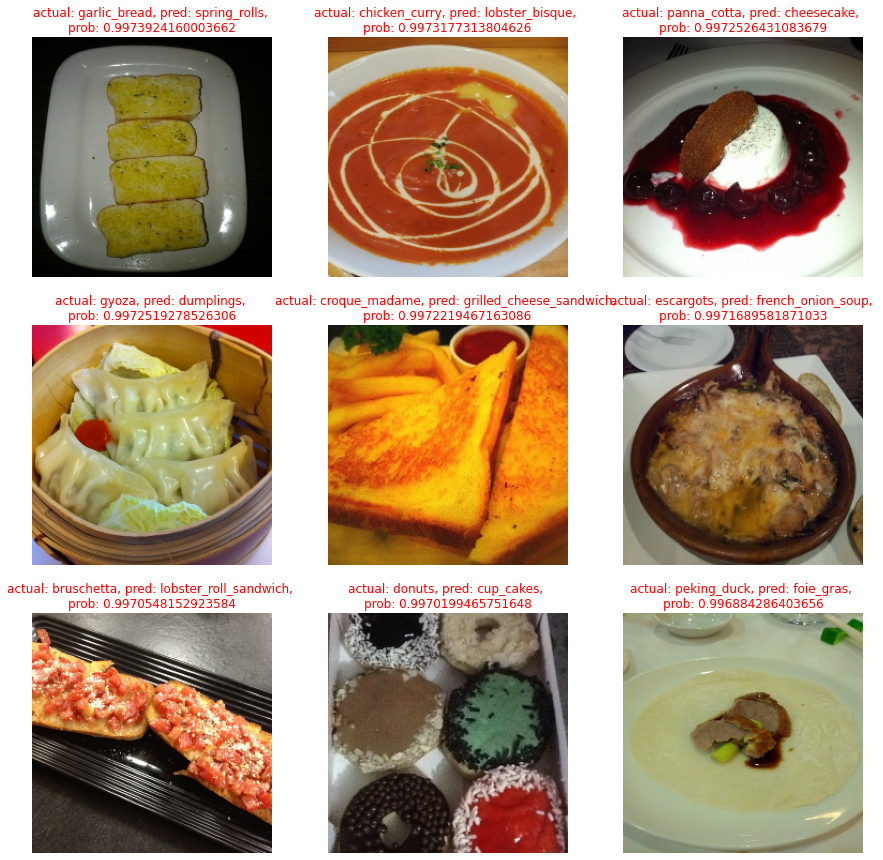

In [ ]:
imgs_to_view=9
start_index=90
plt.figure(figsize=(15,15))
for i,row in enumerate(top_100_wrong[start_index:start_index+imgs_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img=load_prep_images(row[1],scale=False)
  plt.imshow(img/255.)
  if row[7]:
    title_color='g'
  else:
    title_color='r'
  plt.title(f"actual: {row[5]}, pred: {row[6]}, \nprob: {row[4]}",c=title_color)
  plt.axis(False);